In [1]:
from __future__ import print_function
from __future__ import division

from ast import literal_eval

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
import time
import h5py
import argparse
import os
import sys

import masked_networks
from tf_plus import learning_phase, batchnorm_learning_phase
from tf_plus import sess_run_dict, add_classification_losses
from tf_plus import summarize_weights
from train_supermask import make_parser, read_input_data, \
    init_model, load_initial_weights, split_and_shape

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
parser = make_parser()
seed = 1
attempt_num = 0
input_dir = "./results/iter_lot_fc_orig/learned_supermasks_seed_{}_attempt_{}/run1".format(
    seed, attempt_num)
args_str = """--train_h5 ./data/mnist_train.h5 --test_h5 ./data/mnist_test.h5
--arch fc_mask --opt sgd --lr 100 --num_epochs 500 --print_every 220
--eval_every 220 --log_every 220 --save_weights --save_every 22000
--tf_seed {}
--init_weights_h5 {}
""".format(seed, input_dir).split()
args = parser.parse_args(args_str)

In [3]:
train_x, train_y = read_input_data(args.train_h5)
test_x, test_y = read_input_data(args.test_h5) # used as val for now
images_scale = np.max(train_x)
if images_scale > 1:
    print('Normalizing images by a factor of {}'.format(images_scale))
    train_x = train_x / images_scale
    test_x = test_x / images_scale


if args.test_batch_size == 0:
    args.test_batch_size = test_y.shape[0]

print('Data shapes:', train_x.shape, train_y.shape, test_x.shape, test_y.shape)
if train_y.shape[0] % args.train_batch_size != 0:
    print("WARNING batch size doesn't divide train set evenly")
if train_y.shape[0] % args.large_batch_size != 0:
    print("WARNING large batch size doesn't divide train set evenly")
if test_y.shape[0] % args.test_batch_size != 0:
    print("WARNING batch size doesn't divide test set evenly")

# build model, masked networks
if args.arch == 'fc_mask':
    model = masked_networks.build_fc_supermask(args)
        
init_model(model, args)
# define_training(model, args)


sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

Normalizing images by a factor of 255
Data shapes: (55000, 28, 28, 1) (55000,) (10000, 28, 28, 1) (10000,)
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [34]:
if not args.init_weights_h5.endswith('/weights'):
    h5file = os.path.join(args.init_weights_h5, 'weights')
else:
    h5file = args.init_weights_h5
hf_weights = h5py.File(h5file, 'r')
init_weights_flat = hf_weights.get('all_weights')[0]
final_weights_flat = hf_weights.get('all_weights')[-1]
current_mask = np.array(hf_weights.get('mask_values'))

shapes = [literal_eval(s) for s in hf_weights.attrs['var_shapes'].decode('utf-8').split(';')]
hf_weights.close()

weight_values = split_and_shape(init_weights_flat, shapes)
final_weight_values = split_and_shape(final_weights_flat, shapes)
gk = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES)
if len(gk) > 9:
    print("You need to restart the kernel - graphkeys have been replicated")

for i, w in enumerate(gk):
   #if 'mask' not in w.name: # HACK for biased masks
    print('loading weights for layer {}: {}'.format(i, w.name))
    w.load(weight_values[i], session=sess)

loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 2: sequential_network/fc_1/mask:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 5: sequential_network/fc_2/mask:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
loading weights for layer 8: sequential_network/fc_3/mask:0


In [75]:
mask_layers = final_weight_values[2::3]
print("Basic info")
all_mask_weights = []
for mask_layer in mask_layers:
    print("Shape:", mask_layer.shape)
    print("Fraction masked:", mask_layer.mean())
    all_mask_weights.append(mask_layer.flatten())
all_mask_weights = np.concatenate(all_mask_weights)
print("Total fraction masked:", all_mask_weights.mean())

Basic info
Shape: (784, 300)
Fraction masked: 0.07955035490236648
Shape: (300, 100)
Fraction masked: 0.8608754016616333
Shape: (100, 10)
Fraction masked: 4.2978359382748605
Total fraction masked: 0.18344981766025714


(array([[10., 10.,  3.,  2.,  0.,  0.,  1., 10., 38., 26.],
        [11., 17.,  6.,  1.,  1.,  1.,  0.,  3., 25., 35.],
        [12., 12.,  4.,  1.,  1.,  1.,  1.,  8., 19., 41.],
        [ 8., 13.,  2.,  0.,  1.,  2.,  3.,  5., 31., 35.],
        [10., 14.,  5.,  1.,  1.,  1.,  0.,  8., 22., 38.],
        [16.,  8.,  1.,  1.,  3.,  1.,  1.,  7., 19., 43.],
        [12., 16.,  2.,  2.,  0.,  0.,  2.,  7., 28., 31.],
        [ 8., 11.,  6.,  0.,  2.,  1.,  0.,  8., 29., 35.],
        [11., 12.,  7.,  5.,  1.,  2.,  3.,  6., 18., 35.],
        [ 6.,  8.,  6.,  6.,  2.,  0.,  2.,  6., 27., 37.]]),
 array([-11.06165981,  -8.76090431,  -6.46014881,  -4.15939331,
         -1.85863781,   0.44211769,   2.74287319,   5.04362869,
          7.34438419,   9.64513969,  11.9458952 ]),
 <a list of 10 BarContainer objects>)

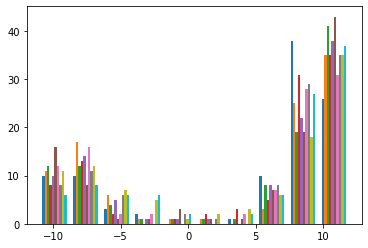

In [79]:
import matplotlib.pyplot as plt
plt.hist(mask_layers[-1])

In [40]:
args.method = 'large_final_same_sign'
args.prev_weights = args.init_weights_h5
args.output_dir = args.init_weights_h5
assert('weights' not in args.output_dir)
args.prune_base = "0.8,0.9"
args.prune_power = 1
args.layer_cutoff = "4,6"
args.seed = args.tf_seed
args.final_weight_interpolation = 1
args.final_weights_ind = -1

In [43]:
args.init_weights_h5

'./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1'

In [49]:
preproc_cmd = (
    'python get_weight_init.py --method ' + args.method +
    ' --weights_h5 ' + args.prev_weights + '/weights' +
    ' --output_h5 ' + args.output_dir + '/init_weights' +
    ' --prune_base ' + args.prune_base +
    ' --prune_power ' + str(args.prune_power) +
    ' --layer_cutoff ' + args.layer_cutoff + 
    ' --seed ' + str(args.seed) +
    ' --final_weight_interpolation ' + str(args.final_weight_interpolation) +
    ' --final_weights_ind ' + str(args.final_weights_ind))
# os.system(preproc_cmd)

In [50]:
import subprocess
subprocess.run(preproc_cmd.split(), capture_output=True)

CompletedProcess(args=['python', 'get_weight_init.py', '--method', 'large_final_same_sign', '--weights_h5', './results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1/weights', '--output_h5', './results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1/init_weights', '--prune_base', '0.8,0.9', '--prune_power', '1', '--layer_cutoff', '4,6', '--seed', '1', '--final_weight_interpolation', '1', '--final_weights_ind', '-1'], returncode=0, stdout=b'==prune percentiles are: \n[19.999999999999996, 0, 19.999999999999996, 0, 9.999999999999998, 0]\n==no mask exists - generating first mask\n', stderr=b'2021-05-30 04:11:57.928472: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0\nget_weight_init.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

In [51]:
if not args.init_weights_h5.endswith('/init_weights'):
    preproc_h5file = os.path.join(args.init_weights_h5, 'init_weights')
else:
    preproc_h5file = args.init_weights_h5
preproc_hf_weights = h5py.File(preproc_h5file, 'r')

In [72]:
mask_flat = np.array(preproc_hf_weights.get('mask_values'))
print(mask_flat.shape)
print(init_weights_flat.shape)

(532810,)
(532810,)


In [73]:
mask_values = split_and_shape(mask_flat, shapes)

In [80]:
mask_layers = mask_values
print("Basic info")
all_mask_weights = []
for mask_layer in mask_layers:
    print("Shape:", mask_layer.shape)
    print("Fraction masked:", mask_layer.mean())
    all_mask_weights.append(mask_layer.flatten())
all_mask_weights = np.concatenate(all_mask_weights)
print("Total fraction masked:", all_mask_weights.mean())

Basic info
Shape: (784, 300)
Fraction masked: 0.8000042517006802
Shape: (300,)
Fraction masked: 1.0
Shape: (784, 300)
Fraction masked: 0.8000042517006802
Shape: (300, 100)
Fraction masked: 1.0
Shape: (100,)
Fraction masked: 0.91
Shape: (300, 100)
Fraction masked: 1.0
Shape: (100, 10)
Fraction masked: -0.002108986273902701
Shape: (10,)
Fraction masked: 0.0
Shape: (100, 10)
Fraction masked: 0.0
Total fraction masked: 0.8196371896430737


(array([[ 7.,  3.,  6., 20., 14., 14., 15.,  9.,  7.,  5.],
        [ 4.,  5.,  9., 13., 15., 17., 17., 15.,  4.,  1.],
        [ 4., 10.,  5., 14., 10., 15., 13., 10., 11.,  8.],
        [ 8.,  7.,  9., 15., 16., 20., 12.,  4.,  6.,  3.],
        [ 4.,  7.,  8., 12., 19., 19., 14., 10.,  6.,  1.],
        [ 7.,  5., 13., 17., 16., 14., 12., 10.,  5.,  1.],
        [ 1.,  8.,  8., 13., 19., 21., 13.,  6.,  7.,  4.],
        [ 5.,  5., 16., 10., 19., 19., 12.,  9.,  4.,  1.],
        [ 4.,  3.,  8.,  8., 16., 18., 17., 16.,  8.,  2.],
        [ 6.,  4., 13., 15.,  9., 13., 16., 13.,  7.,  4.]]),
 array([-0.30366468, -0.24307908, -0.18249348, -0.12190787, -0.06132227,
        -0.00073667,  0.05984893,  0.12043454,  0.18102014,  0.24160574,
         0.30219135]),
 <a list of 10 BarContainer objects>)

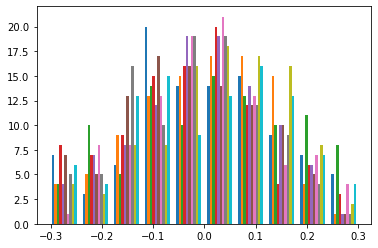

In [81]:
import matplotlib.pyplot as plt
plt.hist(mask_layers[-3])